# Merchant Transactions Analysis:
**About the data**</br>
 The dataset has future merchant transaction activity, for merchants that start over a 2 year period (2033-2034). The data spans from 1/1/33 through 12/31/34.</br>
 </br>
 We are interested in two questions:


> 1.   Understand payments activity to try to infer the types of merchants using the service. 
> 2.   Identify and predict churn </br>

 </br>
*Note: This doc aims to give clear explanations of my thoughts and methods for this analysis so I will add more details. it is not a formal business report*







## Exploratory Data Analysis

To better understand the data and process the data for further analysis; 
This part will include: </br>

> 1.   Data Cleaning
2.   Data Exploration and visualization
3.   Data Preprocessing









### Data Cleaning


In [ ]:
#import library
from termcolor import colored as cl # text customization
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve,precision_recall_curve,auc
from sklearn.cluster import KMeans
from sklearn import preprocessing

In [ ]:
df = pd.read_csv("takehome_ds_written.csv", index_col = 0)
df.head()

,merchant,time,amount_usd_in_cents
1,faa029c6b0,2034-06-17 23:34:14,6349
2,ed7a7d91aa,2034-12-27 00:40:38,3854
3,5608f200cf,2034-04-30 01:29:42,789
4,15b1a0d61e,2034-09-16 01:06:23,4452
5,4770051790,2034-07-22 16:21:42,20203


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1513719 entries, 1 to 1513719
Data columns (total 3 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   merchant             1513719 non-null  object
 1   time                 1513719 non-null  object
 2   amount_usd_in_cents  1513719 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 46.2+ MB


Let's look at the data first, we noticed, there are three columns in the data: merchant, time, and amount used in cents
</br>
There is no missing values so we don't need to do any imputation </br>
For understanding convenience, let's convert the cents into dollars and drop the *'amount_usd_in_cents'* column

In [ ]:
df['amount_usd_in_dollars'] = df.amount_usd_in_cents/100
df1 = df.drop(['amount_usd_in_cents'], axis=1)

In [ ]:
df1.head()

,merchant,time,amount_usd_in_dollars
1,faa029c6b0,2034-06-17 23:34:14,63.49
2,ed7a7d91aa,2034-12-27 00:40:38,38.54
3,5608f200cf,2034-04-30 01:29:42,7.89
4,15b1a0d61e,2034-09-16 01:06:23,44.52
5,4770051790,2034-07-22 16:21:42,202.03


In [ ]:
df1.describe()

,amount_usd_in_dollars
count,1.513719e+06
mean,1.548466e+02
std,6.161886e+02
min,2.010000e+00
25%,3.215000e+01
50%,6.104000e+01
75%,1.260600e+02
max,2.592028e+05


Now let's check if there is any wrong/unrealistic data points </br>
The data isn't too complicated, and the main thing we need to check is if the amound used in dollars is larger than zero, cause if not, we may encounter a fraud or other tech issue and that's out of our scope this time





In [ ]:
df1[(df1['amount_usd_in_dollars']<0)]

,merchant,time,amount_usd_in_dollars


We noticed all of our amount is positive so our data is in good shape </br>
Now let's look at the distribution of amount used in dollars and see if we need to deal with outliers

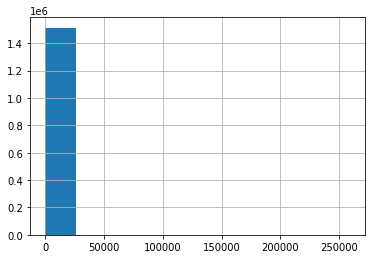

In [ ]:
df1['amount_usd_in_dollars'].hist()

We noticed there is potential outlier to our data
</br>
Let's take a look at the max and min value for transactions and which merchants are related to them 

In [ ]:
df1['amount_usd_in_dollars'].max()

259202.8

In [ ]:
df1['amount_usd_in_dollars'].min()

2.01

In [ ]:
df1[(df1['amount_usd_in_dollars']==259202.8)]
df1[(df1['merchant']=='0838e4078e')]

,merchant,time,amount_usd_in_dollars
596898,0838e4078e,2034-04-29 16:21:18,2063.00
725232,0838e4078e,2034-06-06 17:59:10,2193.73
1393899,0838e4078e,2034-08-04 18:53:26,259202.80


In [ ]:
df1[(df1['amount_usd_in_dollars']==2.01)]

,merchant,time,amount_usd_in_dollars
71854,3ee378c358,2034-12-04 06:57:32,2.01
76819,c5b09bf41e,2034-11-29 06:56:35,2.01
104032,abd48df37f,2034-09-11 04:40:23,2.01
108460,73e20f6c65,2034-05-27 21:44:27,2.01
128085,23f7a2b8b5,2034-02-02 16:18:18,2.01
...,...,...,...
1387672,abd48df37f,2034-09-11 16:37:59,2.01
1401647,89e2d29885,2034-04-10 12:21:14,2.01
1460734,72c2cdfb6a,2033-11-18 07:11:57,2.01
1487447,d6fe440e06,2034-09-01 23:32:36,2.01


There is only one merchant with the max transaction, and the other transactions associated with this merchant is not really small, this transaction is potentially a wrong record, but there might be other reasons, let's keep this record and we will pay attention to this merchant when we do analysis later </br>
There are 61 transactions with the min value, nothing to be worried about. </br>


### Data Exploration and Preprocessing

Now, we noticed there are only several transactions with amount larger than 25000 usd, to better understand the data, I will inspect the transactions within range 25000 usd

In [ ]:
df1[(df1['amount_usd_in_dollars']>25000)]

,merchant,time,amount_usd_in_dollars
24186,ed184b7e75,2034-09-07 11:03:37,30550.92
28978,b993083163,2034-10-16 21:29:24,103855.08
35263,69821cf0e2,2034-11-29 15:36:06,27218.13
47559,95efa5154d,2034-10-24 15:32:53,45708.61
50771,29f7ac8ef4,2033-11-25 22:35:20,25784.11
...,...,...,...
1429658,60fbdf7cfa,2034-08-08 00:41:34,47846.71
1442960,79495b0a8c,2034-12-28 15:31:56,91559.76
1465055,1e941a2507,2034-08-24 16:14:10,42248.28
1467395,b993083163,2034-10-04 01:00:02,85319.07


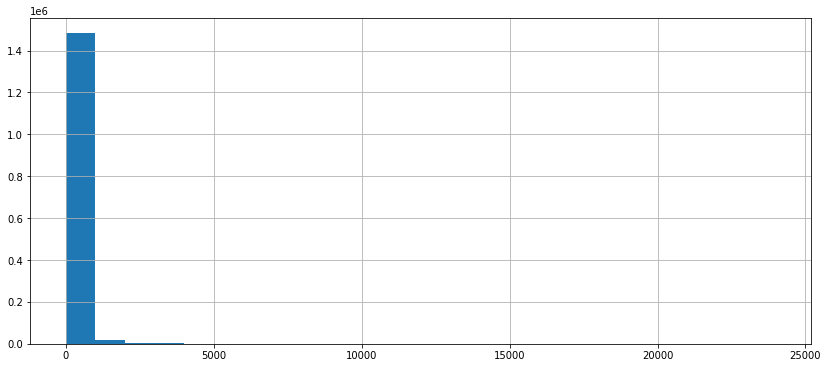

In [ ]:
bin_values = np.arange(start=0, stop=25000, step=1000)
df1['amount_usd_in_dollars'].hist(bins=bin_values, figsize=[14,6])

We can see most transaction amounts are relatively small, but there are also some transactions with larger amount, so it is valuable to pay attention to different amounts when we do user segmentation later. </br>
</br>
Now, let's take a look at some more insights

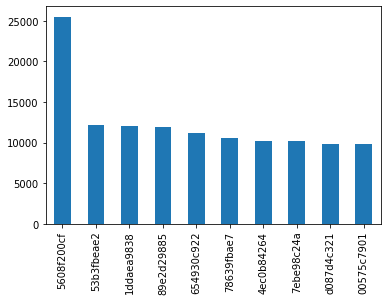

In [ ]:
#top ten active merchants 
df1.merchant.value_counts()[:10].plot(kind='bar')

In [ ]:
#add a new column frequency to identify active users
df1['frequency'] = df1['merchant'].map(df1['merchant'].value_counts())

In [ ]:
#add new column average amount to identify high spenders
df1['average_amount'] = df1.groupby(['merchant'])['amount_usd_in_dollars'].transform('mean')

In [ ]:
df1.head()

,merchant,time,amount_usd_in_dollars,frequency,average_amount
1,faa029c6b0,2034-06-17 23:34:14,63.49,544,167.299926
2,ed7a7d91aa,2034-12-27 00:40:38,38.54,16,169.585000
3,5608f200cf,2034-04-30 01:29:42,7.89,25512,8.196759
4,15b1a0d61e,2034-09-16 01:06:23,44.52,521,57.656392
5,4770051790,2034-07-22 16:21:42,202.03,574,452.910767


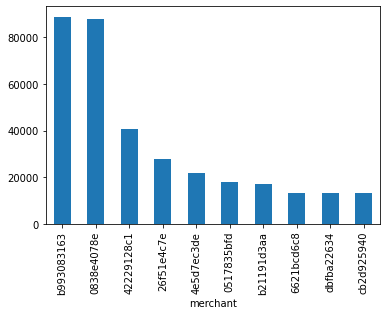

In [ ]:
df1.groupby('merchant')['amount_usd_in_dollars'].mean().nlargest(10).plot(kind='bar')
#notice the merchant with the largest amount transaction is at the top2
#we have two merchants with extreme high transaction amount

It's interesting to notice that the merchants with highest spendings and the merchants with most number of transactions are not overlapping. 


In [ ]:
# convert time from string to date 
df1['time'] = pd.to_datetime(df1['time'])
# create columns for year and month of the time
df1['year'] = df1['time'].dt.strftime('%Y')
df1['month'] = df1['time'].dt.strftime('%m')

In [ ]:
df1.head()

,merchant,time,amount_usd_in_dollars,frequency,average_amount,year,month
1,faa029c6b0,2034-06-17 23:34:14,63.49,544,167.299926,2034,06
2,ed7a7d91aa,2034-12-27 00:40:38,38.54,16,169.585000,2034,12
3,5608f200cf,2034-04-30 01:29:42,7.89,25512,8.196759,2034,04
4,15b1a0d61e,2034-09-16 01:06:23,44.52,521,57.656392,2034,09
5,4770051790,2034-07-22 16:21:42,202.03,574,452.910767,2034,07


In [ ]:
#number of unique merchants in our data
df1['merchant'].nunique()

14351

In [ ]:
# check those merchants who are active in both 2033 and 2034
df2 = df1.groupby('merchant').filter(lambda x: {'2034', '2033'}.issubset(x['year']))
df2['merchant'].nunique()
#4464 out of 14351 merchants are active in both years

4464

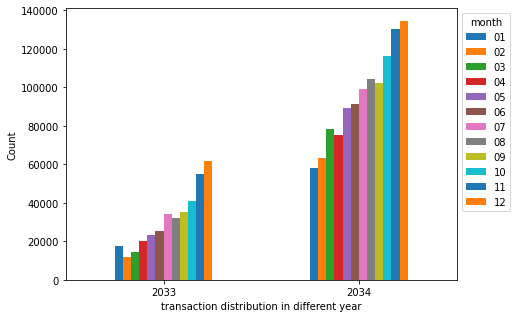

In [ ]:
dfu = df1.groupby(['year']).month.value_counts().unstack()
ax = dfu.plot(kind='bar', figsize=(7, 5), xlabel='transaction distribution in different year', ylabel='Count', rot=0)
ax.legend(title='month', bbox_to_anchor=(1, 1), loc='upper left')
#we have most transactions at the end of each year
#we have much more transactions in 2034 than 2033

In [ ]:
#since this is a made-up data, so we will get the most recent transaction date as our present date
present = df1['time'].max()
print(present)

2034-12-31 07:59:40


## Question 1: Identify different business (User Segmentation)

This question asks: "Using only the given data, how would you identify different kinds of businesses in the sample? Please generate assignments for each merchant." There are many ways to tackle down this problem, the one I chose is called ***"RMF Analysis"*** </br>
</br>
"RFM (Recency, Frequency, Monetary) analysis is a behavior-based approach grouping customers into segments. It groups the customers on the basis of their previous purchase transactions. How recently, how often, and how much did a customer buy. " ([reference](https://academicjournals.org/article/article1380555311_Wei%20et%20al%20(1)3334.pdf))</br>
</br>
The main reason I use this method is not only because our data only have timestamp and money value, but also this is one of the most effective way of user segmentation, and it allows us to determine churned customer easily. </br>
Customers with the lowest recency, highest frequency and monetary amounts considered as top customer</br>
</br>




> create a new dataframe with recency, frequency and monetary value of each merchant </br>
**RECENCY:** Days since last purchase </br>
**FREQUENCY:** Total number of purchases </br>
**MONETARY VALUE:** Total money this customer spent </br>





In [ ]:
#add a new column : invoiceNo to record as the index of our records
df1['invoiceNo'] = range(1, len(df1) + 1)

In [ ]:

df2= df1.groupby('merchant').agg({'time': lambda date: (present - date.max()).days,
                                        'invoiceNo': lambda num: len(num),
                                        'amount_usd_in_dollars': lambda price: price.sum()})

In [ ]:
df2.columns=['recency','frequency','monetary']

In [ ]:
df2.head()

,recency,frequency,monetary
merchant,,,
0002b63b92,593,1,33.79
0002d07bba,15,4,892.78
00057d4302,514,28,295.21
000bcff341,508,1,78.26
000ddbf0ca,576,1,102.99


In [ ]:
df2.describe()

,recency,frequency,monetary
count,14351.000000,14351.000000,1.435100e+04
mean,136.266532,105.478294,1.633296e+04
std,174.497343,527.717966,6.431726e+04
min,0.000000,1.000000,2.010000e+00
25%,9.000000,3.000000,3.626300e+02
50%,51.000000,11.000000,1.602620e+03
75%,212.000000,45.000000,8.230995e+03
max,728.000000,25512.000000,2.369072e+06


### Split metrics

There are 8 general segments for RMF based on quartiles on Recency, Monetary and Frequency </br>

> *There are more segments, but we care the most of these*





*   Best Customers(RMF 111): Bought most recently, and most often, spend the most
*   Loyal Customers(RMF X1X): Buy most frequently and recently
*   Big Spenders(RMF XX1): Spend the most
*   Active Customers(RMF 1XX): Spend most recently
*   Almost Lost (RMF 3XX): Haven't purchased for a period of time
*   Lost Customers(RMF 4XX): Haven't purchsed for long time
*   Faithful Customers(RMF X13,X14): return often, but not spend a lot
*   Other active Customers





In [ ]:
quantiles = df2.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [ ]:
#create a segmented RMF table
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

segmented_rfm = df2 
segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary'].apply(FMScore, args=('monetary',quantiles,))
#create RMF score based on quartile for recency, frequency and monetary
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFMScore
merchant,,,,,,,
0002b63b92,593,1,33.79,4,4,4,444
0002d07bba,15,4,892.78,2,3,3,233
00057d4302,514,28,295.21,4,2,4,424
000bcff341,508,1,78.26,4,4,4,444
000ddbf0ca,576,1,102.99,4,4,4,444


In [ ]:
segmented_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14351 entries, 0002b63b92 to fff1754102
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   recency     14351 non-null  int64  
 1   frequency   14351 non-null  int64  
 2   monetary    14351 non-null  float64
 3   r_quartile  14351 non-null  int64  
 4   f_quartile  14351 non-null  int64  
 5   m_quartile  14351 non-null  int64  
 6   RFMScore    14351 non-null  object 
dtypes: float64(1), int64(5), object(1)
memory usage: 896.9+ KB


In [ ]:
def segment(row):
  if row['RFMScore']=='111':
    return 'Best Customer'
  elif row['f_quartile']==1 & row['m_quartile']>=3:
    return 'Faithful Customer'
  elif row['f_quartile']==1:
    return 'Loyal Customer'
  elif row['r_quartile']==1:
    return 'Active Customer'
  elif row['m_quartile']==1:
    return 'Big Spender'
  elif row['r_quartile']==3:
    return 'Almost Lost'
  elif row['r_quartile']==4:
    return 'Lost Customer'
  else:
    return 'Other Active Customer'

In [ ]:
segmented_rfm['segments'] = segmented_rfm.apply(segment, axis=1)

Lost Customer            3075
Almost Lost              2908
Other Active Customer    2457
Loyal Customer           1858
Best Customer            1683
Active Customer          1609
Big Spender               761
Name: segments, dtype: int64


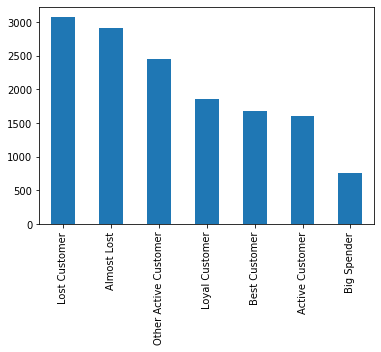

In [ ]:

segmented_rfm.segments.value_counts().plot(kind='bar')
print(segmented_rfm['segments'].value_counts()) 

In [ ]:
#put segments back to original data to get more insights
segmented_rfm.reset_index(inplace=True)
df3 = pd.merge(df1, segmented_rfm, on="merchant")

In [ ]:
# to avoid overcounting merchants
df3_=df3.drop_duplicates(subset=['merchant'])

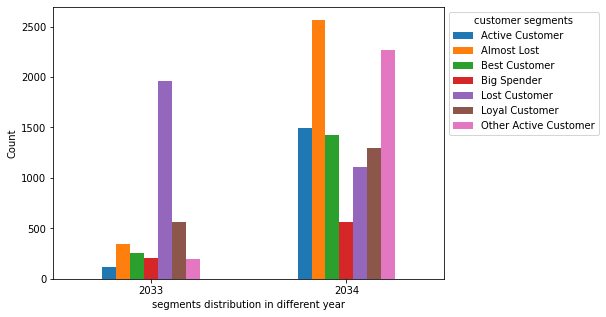

In [ ]:
plt = df3_.groupby(['year']).segments.value_counts().unstack()
ax = plt.plot(kind='bar', figsize=(7, 5), xlabel='segments distribution in different year', ylabel='Count', rot=0)
ax.legend(title='customer segments', bbox_to_anchor=(1, 1), loc='upper left')

> We can tell for both years, there are lots of Lost customers in 2033, and the percentage reduced a lot in 2034

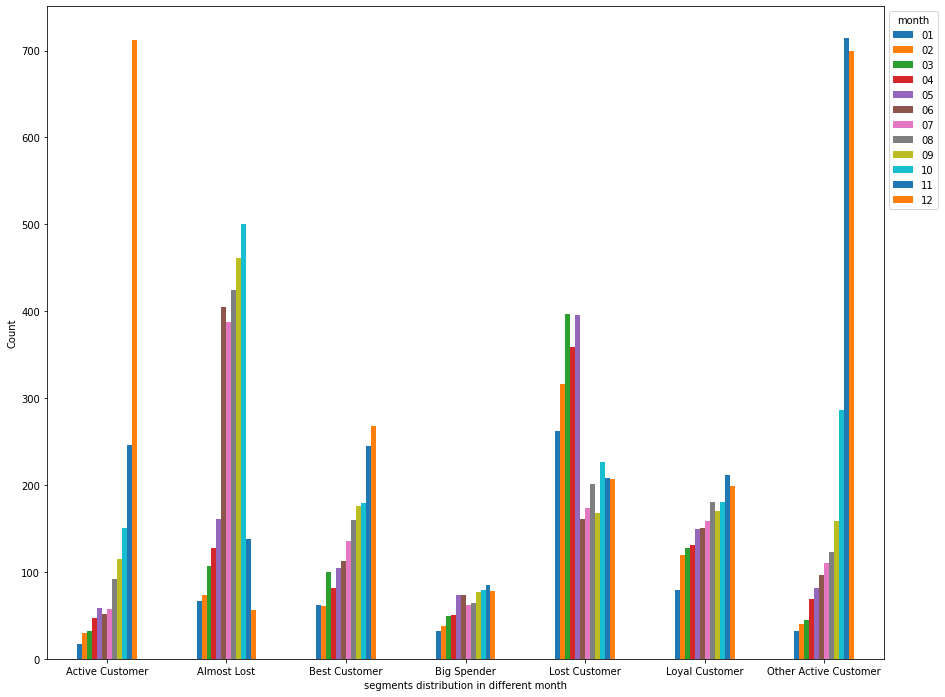

In [ ]:
plt = df3_.groupby(['segments']).month.value_counts().unstack()
ax = plt.plot(kind='bar', figsize=(15, 12), xlabel='segments distribution in different month', ylabel='Count', rot=0)
ax.legend(title='month', bbox_to_anchor=(1, 1), loc='upper left')

> Insights: </br>


*   There are the highest number of best customers and active customers in December.
*   Customers' loyalty increases along the year
*   Customers become more active along the year
*   Customers spend similarly in each month
*   We normally lose customers during March and May


</br>


## Question 2 : Customer Churn Analysis

This part solve the problems: </br>


> 1. Identify merchants that have already churned in the dataset
2. Build a model to predict which active merchants are most likely to churn in the near future

**We define churn as :** </br>
When an existing customer, user, subscriber, or any kind of return client stops doing business or ends the relationship with the company over a defined period of time, and usually measured per month</br>
</br>
By analyzing customer churn, we can find a potential way to reduce our customer churn rate, in return as increasing number of active users. </br>
The following part will discuss how we can identify a churned customer and a potential churn customer. Then there are many ways the team can do to possibly get the customer back, one of the most potential way is to send emails with coupon or benefits to the customers to help them stay.


### Part 1: Identify Churned Merchant



> in the previous parts, we have created dataset with recency, which describes how many days has past since the last day the merchant is active </br>


K-means clustering is used to cluster the merchants into churned and non churned groups. </br>

The K-Means is an unsupervised learning algorithm and one of the simplest algorithm used for clustering tasks.</br>
The values which are within a cluster are very similar to each other but, the values across different clusters vary enormously.</br>
 K-Means clustering works really well with medium and large-sized data.



In [ ]:
df2.head()

,merchant,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFMScore,segments
0,0002b63b92,593,1,33.79,4,4,4,444,Lost Customer
1,0002d07bba,15,4,892.78,2,3,3,233,Other Active Customer
2,00057d4302,514,28,295.21,4,2,4,424,Lost Customer
3,000bcff341,508,1,78.26,4,4,4,444,Lost Customer
4,000ddbf0ca,576,1,102.99,4,4,4,444,Lost Customer


In [ ]:
df_kmeans= df2[['recency', 'frequency', 'monetary']]

In [ ]:
#standardization
## data transformation: K-means is sensitive to variance in data, and features with larger variance have more emphasis on result
X = preprocessing.normalize(df_kmeans) 

In [ ]:
#set cluster to 2
clusters = 2
model = KMeans(init = 'k-means++', #minimize the variance 
               n_clusters = clusters, 
               n_init = 12)
model.fit(X)

KMeans(n_clusters=2, n_init=12)

In [ ]:
#get the labels 
labels = model.labels_
print(cl(labels[:100], attrs = ['bold']))

[1 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0]


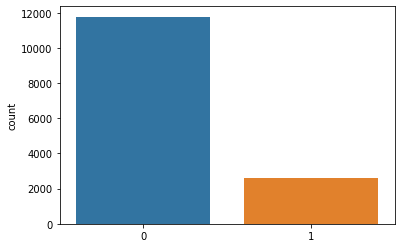

In [ ]:
#check the distribution of each cluster
sns.countplot(labels)

> most of our customers haven't churned

In [ ]:
df2['churn'] = labels
df2.head()

,merchant,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFMScore,segments,churn
0,0002b63b92,593,1,33.79,4,4,4,444,Lost Customer,1
1,0002d07bba,15,4,892.78,2,3,3,233,Other Active Customer,0
2,00057d4302,514,28,295.21,4,2,4,424,Lost Customer,1
3,000bcff341,508,1,78.26,4,4,4,444,Lost Customer,1
4,000ddbf0ca,576,1,102.99,4,4,4,444,Lost Customer,1


In [ ]:
#get the distribution of churn 
print(df2['churn'].value_counts()) 

0    11773
1     2578
Name: churn, dtype: int64


> Identify customers who already churned in the dataset

In [ ]:
df2[(df2['churn']==1)]

,merchant,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFMScore,segments,churn
0,0002b63b92,593,1,33.79,4,4,4,444,Lost Customer,1
2,00057d4302,514,28,295.21,4,2,4,424,Lost Customer,1
3,000bcff341,508,1,78.26,4,4,4,444,Lost Customer,1
4,000ddbf0ca,576,1,102.99,4,4,4,444,Lost Customer,1
7,001f7b7a4f,303,1,64.44,4,4,4,444,Lost Customer,1
...,...,...,...,...,...,...,...,...,...,...
14338,ffaeb2e3ce,651,1,53.44,4,4,4,444,Lost Customer,1
14341,ffc06f74ff,158,2,102.35,3,4,4,344,Almost Lost,1
14342,ffc46fd720,204,6,200.58,3,3,4,334,Almost Lost,1
14346,ffd3e45675,703,5,726.26,4,3,3,433,Lost Customer,1




> Find out how churned and non churned customers are different in frequency and monetary



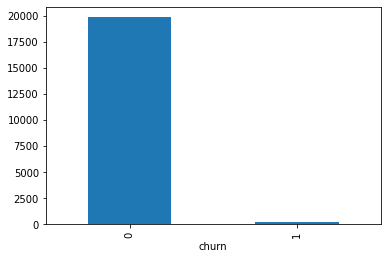

In [ ]:
df2.groupby('churn')['monetary'].mean().plot(kind='bar')

not surprisingly, non churned customers have much more total transaction amount than churned customers, and that's one of the reason why we need to try to reduce customer churn rate

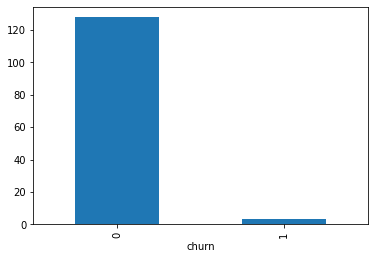

In [ ]:
df2.groupby('churn')['frequency'].mean().plot(kind='bar')

also not surprisingly, non churned customers have much higher frequency than churned customers, reduced number of transactions will eventually result in reduced revenue

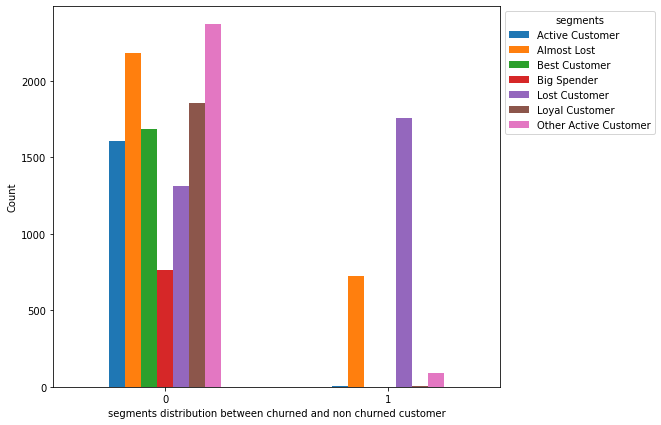

In [ ]:
plt = df2.groupby(['churn']).segments.value_counts().unstack()
ax = plt.plot(kind='bar', figsize=(8, 7), xlabel='segments distribution between churned and non churned customer', ylabel='Count', rot=0)
ax.legend(title='segments', bbox_to_anchor=(1, 1), loc='upper left')

> This plot, again, proved the correctness of our definition of churn. </br>
 

*   The majority segments for churned customers are *'Almost Lost'* and *'Lost Customers'* Which as we expected
*   There is no *'Active Customer'* or *'Best Customer'* in churned group
*   In non churned group, numbers of other active customers is large, gives us a hint that there is some potentials for us to divide the *'Other Active Customers'* further.



### Part 2: Predict Potential Customer Churn

To possibly reduce customer churn rate, we need to firstly predict which active customer may churn in the future and take actions with these customers. </br>
This part will include: </br>
> 1. Model Training and Selection 
2. Optimize Hyperparameters with Grid Search
3. Model Evaluation
4. Feature Selection

**Models used:** Logistic Regression, K Nearest Neighbor, Random Forest </br>


#### Part 2.1: Model Training and Selection

In [ ]:

df_agg= df1.groupby('merchant').agg({'time': lambda date: date.max(),
                                        'invoiceNo': lambda num: len(num),
                                        'amount_usd_in_dollars': lambda price: price.mean()})

In [ ]:
df=df2[['merchant','churn']]
df4 = pd.merge(df_agg, df, on="merchant")

In [ ]:
df4['frequency'] = df4['invoiceNo']

In [ ]:
df4['time']= pd.to_datetime(df4['time'])
df4['hour'] = df4['time'].dt.hour
df4['day'] = df4['time'].dt.day
df4['year']= df4['time'].dt.year
df4['month']= df4['time'].dt.month

df4.head()

,merchant,time,invoiceNo,amount_usd_in_dollars,churn,frequency,hour,day,year,month
0,0002b63b92,2033-05-16 20:07:57,1,33.790000,1,1,20,16,2033,5
1,0002d07bba,2034-12-15 09:56:19,4,223.195000,0,4,9,15,2034,12
2,00057d4302,2033-08-04 04:26:40,28,10.543214,1,28,4,4,2033,8
3,000bcff341,2033-08-09 20:18:36,1,78.260000,1,1,20,9,2033,8
4,000ddbf0ca,2033-06-02 13:25:12,1,102.990000,1,1,13,2,2033,6


In [ ]:
#sample out some amount of unchurned data for later prediction
potential=df4[df4.churn == 0].sample(9000)

In [ ]:
df4.drop(potential['merchant'].index, inplace = True)

In [ ]:
df_model = df4[['amount_usd_in_dollars','frequency','year','month','day','hour','churn']]


In [ ]:
df_model.head()

,amount_usd_in_dollars,frequency,year,month,day,hour,churn
0,33.790000,1,2033,5,16,20,1
2,10.543214,28,2033,8,4,4,1
3,78.260000,1,2033,8,9,20,1
4,102.990000,1,2033,6,2,13,1
6,119.144517,290,2034,12,30,16,0


In [ ]:
#convert string to integer
df_model['month'] = df_model['month'].astype(int, errors = 'raise')
df_model['year'] = df_model['year'].astype(int, errors = 'raise')
df_model['day'] = df_model['day'].astype(int, errors = 'raise')
df_model['hour'] = df_model['hour'].astype(int, errors = 'raise')

> The chosen predictos show low correlations with each other 

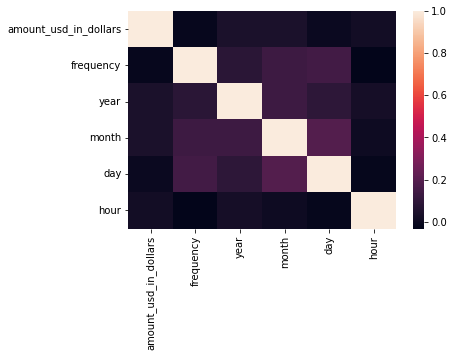

In [ ]:
corr = df_model[['amount_usd_in_dollars','frequency','year','month','day','hour']].corr()

# show heapmap of correlations
sns.heatmap(corr)

In [ ]:
#split dataset
# Reserve 30% for testing
X= df_model[['amount_usd_in_dollars','frequency','year','month','day','hour']]
y = df_model['churn']
X_train, X_test, y_train1, y_test = model_selection.train_test_split(X, y, test_size=0.3)

print('training data has %d observation with %d features'% X_train.shape)
print('test data has %d observation with %d features'% X_test.shape)

training data has 3745 observation with 6 features
test data has 1606 observation with 6 features


In [ ]:
#get the distribution of churn 
print(df_model['churn'].value_counts()) #imbalanced

0    2773
1    2578
Name: churn, dtype: int64


> The class is imbalanced, which may introduce bias in our classifier results. here is a high probability of misclassification of the minority class as compared to the majority class.

In [ ]:
# data transformation: to speed up gradient descent in later optimization part and to keep the data in the same scale
scaler = StandardScaler()

X_train1 = scaler.fit_transform(X_train) # calculate the scaling from train, and apply it to train, scaling is stored in scaler
X_test = scaler.transform(X_test) #apply the saved scaling to testing data

> Use SMOTE to balance the data, SMOTE works by utilizing a k-nearest neighbour algorithm to create synthetic data. Traditional undersampling and oversampling may introduce loss of information for our data

In [ ]:
#it's important to generate the new samples only in the training set to ensure our model generalizes well to unseen data.(avoid overfitting)
sm = SMOTE(random_state = 25, sampling_strategy = 1.0)  
# fit the sampling
X_train, y_train = sm.fit_resample(X_train1, y_train1)

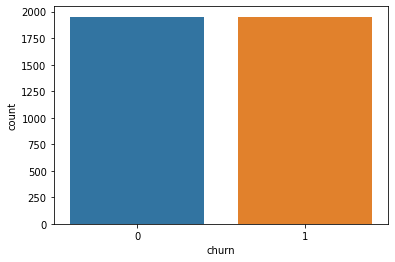

In [ ]:
sns.countplot(y_train)
#the data is balanced

> Building the models

In [ ]:
#Define objects 
# Logistic Regression
classifier_logistic = LogisticRegression()

# K Nearest Neighbors
classifier_KNN = KNeighborsClassifier()



In [ ]:
# Train the model
classifier_logistic.fit(X_train, y_train)
classifier_KNN.fit(X_train, y_train)


RandomForestClassifier()

In [ ]:
# Prediction of test data

prediction_logistic = (classifier_logistic.predict_proba(X_test)[:,1]>=0.6).astype(int)
prediction_knn = (classifier_KNN.predict_proba(X_test)[:,1]>=0.6).astype(int)


In [ ]:
# Accuracy of test data

print("the accuracy of logistic model is: ",classifier_logistic.score(X_test, y_test) )#accuracy
print("the recall of logistic model is: ",metrics.recall_score(y_test,prediction_logistic)) #get recall
print("the precision of logistic model is: ",metrics.precision_score(y_test,prediction_logistic)) #get precision


the accuracy of logistic model is:  0.8841843088418431
the recall of logistic model is:  0.824203821656051
the precision of logistic model is:  0.8790760869565217


In [ ]:
print("the accuracy of knn model is: ",classifier_KNN.score(X_test, y_test) )#accuracy
print("the recall of knn model is: ",metrics.recall_score(y_test,prediction_knn)) #get recall, the recall is really low, means we predict many positive as negative
print("the precision of knn model is: ",metrics.precision_score(y_test,prediction_knn)) #get precision


the accuracy of knn model is:  0.8001245330012453
the recall of knn model is:  0.8662420382165605
the precision of knn model is:  0.7589285714285714


### Part 2.2 Find optimal hyperparameters

In [ ]:

# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: %0.3f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

>KNN

In [ ]:
# Possible hyperparamter options for KNN
# Choose k
parameters = {
    'n_neighbors':[3,5,7,10] 
}
Grid_KNN = GridSearchCV(KNeighborsClassifier(),parameters, cv=5)
Grid_KNN.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 10]})

In [ ]:
# best k
print_grid_search_metrics(Grid_KNN)

Best score: 0.832
Best parameters set:
	n_neighbors: 7


In [ ]:
#best knn model
best_KNN_model = Grid_KNN.best_estimator_

> Logistic Regression

In [ ]:
# Possible hyperparamter options for Logistic Regression Regularization
# Penalty is choosed from L1 or L2
# C is the lambda value(weight) for L1 and L2

parameters = {
    'penalty':('l1', 'l2'), 
    'C':(1, 3, 5)
} #try different parameters to get a better result 
Grid_LR = GridSearchCV(LogisticRegression(),parameters, cv=5)
Grid_LR.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': (1, 3, 5), 'penalty': ('l1', 'l2')})

In [ ]:
# the best hyperparameter combination
print_grid_search_metrics(Grid_LR)

Best score: 0.920
Best parameters set:
	C: 5
	penalty: 'l2'


In [ ]:
# best model
best_LR_model = Grid_LR.best_estimator_

> Random Forest

### Part 3: Model Evaluation

> Calculate AUC score: It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1.

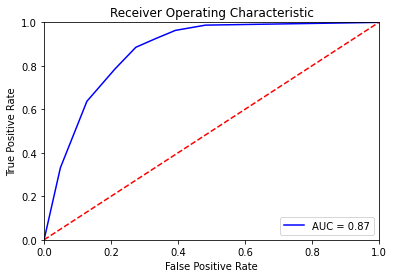

In [ ]:
# calculate the fpr and tpr for all thresholds of the classification
probs = best_KNN_model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# AUC score
metrics.auc(fpr,tpr)

0.8696129467714532

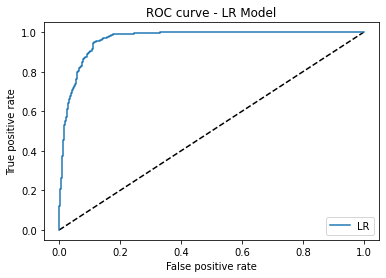

In [ ]:
# Use predict_proba to get the probability results of Logistic Regression
y_pred_lr = best_LR_model.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - LR Model')
plt.legend(loc='best')
plt.show()

In [ ]:
# AUC score
metrics.auc(fpr_lr,tpr_lr)

0.9643653459739171

In [ ]:
# calculate accuracy, precision and recall, [[tn, fp],[]]
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not','Churn']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

> Get confusion matrix; Compare recall, precision and accuracy
</br>
Most times it's not enough to just look at accuracy of our model</br>
For predicting churn, we care more about precision to optimize our marketing strategy

Logistic Regression
Accuracy is: 0.912
precision is: 0.890
recall is: 0.936


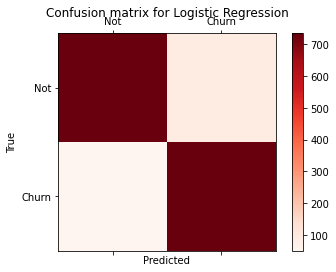

In [ ]:
%matplotlib inline

# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    
    ("Logistic Regression", confusion_matrix(y_test,best_LR_model.predict(X_test))),
]

draw_confusion_matrices(confusion_matrices)

KNN
Accuracy is: 0.804
precision is: 0.755
recall is: 0.885


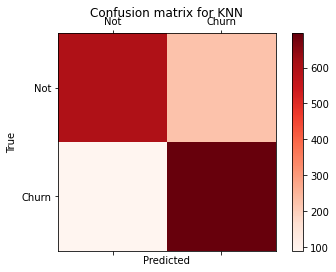

In [ ]:
confusion_matrices = [
    
    ("KNN", confusion_matrix(y_test,best_KNN_model.predict(X_test))),
]

draw_confusion_matrices(confusion_matrices)

### Part 4: Predict future potential churn for non churned customers in the data

> To get more insights of our data; to see which merchants may churn in the future, we apply our model to customers who have not churned yet

In [ ]:
potential['month'] = potential['month'].astype(int, errors = 'raise')
potential['year'] = potential['year'].astype(int, errors = 'raise')
potential['day'] = potential['day'].astype(int, errors = 'raise')
potential['hour'] =potential['hour'].astype(int, errors = 'raise')

In [ ]:
potential_X= potential[['amount_usd_in_dollars','frequency','year','month','day','hour']]
potential_X= scaler.fit_transform(potential_X) # calculate the scaling from train, and apply it to train, scaling is stored in scaler


> use KNN to get a balance of recall and precision

In [ ]:
prediction = pd.DataFrame(best_LR_model.predict(potential_X))
prediction.columns = ['prediction']

> Take a look at the distribution of potential churned customers

1    5387
0    3613
Name: prediction, dtype: int64


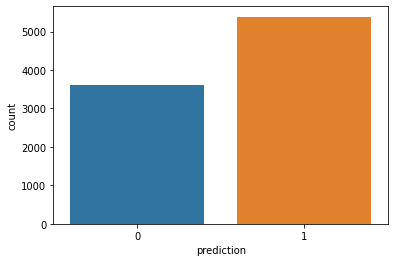

In [ ]:
sns.countplot(prediction['prediction'])
print(prediction['prediction'].value_counts())

>Put predicted results back to data to get some insights

In [ ]:
prediction.reset_index(inplace=True)

In [ ]:
result = pd.merge(prediction,potential)

In [ ]:
result.head()

,index,prediction,level_0,merchant,time,invoiceNo,amount_usd_in_dollars,churn,frequency,hour,day,year,month
0,0,1,0,e96b91fac9,2034-10-24 02:01:50,4,76.227500,0,4,2,24,2034,10
1,1,1,1,2b72a6326a,2034-09-27 17:45:36,9,328.717778,0,9,17,27,2034,9
2,2,1,2,14b4c07e0b,2034-11-18 18:19:14,1,102.080000,0,1,18,18,2034,11
3,3,1,3,ea1505682a,2034-12-28 22:11:56,4,267.997500,0,4,22,28,2034,12
4,4,0,4,b16d6f205b,2034-12-12 15:40:58,5,870.626000,0,5,15,12,2034,12


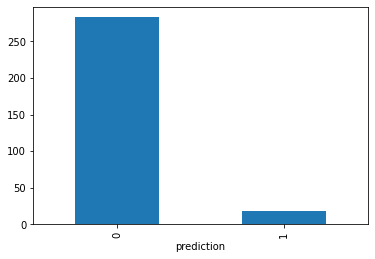

In [ ]:
result.groupby('prediction')['frequency'].mean().plot(kind='bar')

> predicted as 'will not churn' customers has much higher frequency

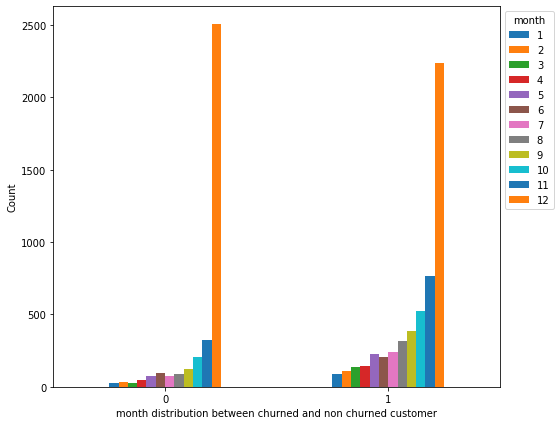

In [ ]:
plt = result.groupby(['prediction']).month.value_counts().unstack()
ax = plt.plot(kind='bar', figsize=(8, 7), xlabel='month distribution between churned and non churned customer', ylabel='Count', rot=0)
ax.legend(title='month', bbox_to_anchor=(1, 1), loc='upper left')

> most predicted as non churn customers have their last purchase in December. 

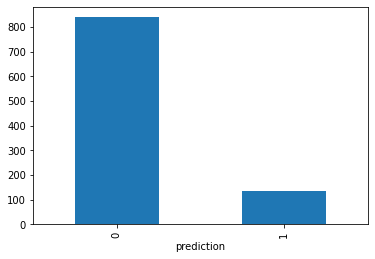

In [ ]:
result.groupby('prediction')['amount_usd_in_dollars'].mean().plot(kind='bar')

> customers spend more tend not to churn as we predicted, 

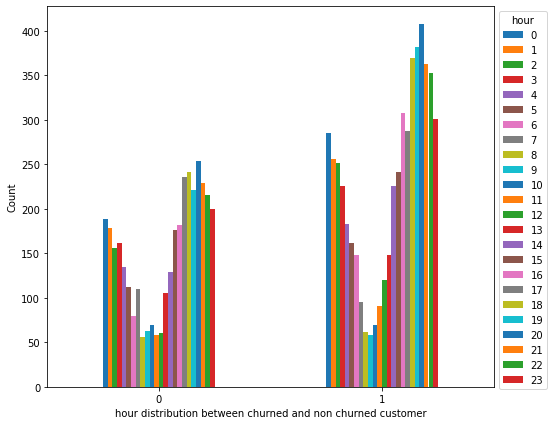

In [ ]:
plt = result.groupby(['prediction']).hour.value_counts().unstack()
ax = plt.plot(kind='bar', figsize=(8, 7), xlabel='hour distribution between churned and non churned customer', ylabel='Count', rot=0)
ax.legend(title='hour', bbox_to_anchor=(1, 1), loc='upper left')

> The distributions are similar 

## Summary

> * Customers' loyalty increases along the year
* We normally lose customers during March and May
* Lots of Lost customers in 2033, and the percentage reduced a lot in 2034
* There are 58% of non churned customers might churn in the future

#### What we can do?

> * Communicate and Collaborate with Marketing and Customer Teams
* Get insights from different perspective
* Engage with the customers likely to churn
</br> Look at their profile, identify characteristics and analyze past interactions
* communicate latest developments
* Provide coupons 
